### Estimativa de Prognóstico de Geração

Desenvolvam um modelo preditivo capaz de estimar a geração futura
de uma usina com potência xxx e localização yyy, considerando a
geração histórica de usinas vizinhas. Esse modelo poderá auxiliar em
planejamentos de expansão e manutenção preventiva das usinas.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
df_unidade_consumidora = pd.read_csv('./datasets/unidade_consumidora')
df_geracao = pd.read_csv('./datasets/geracao', chunksize=1000000)
df_usina = pd.read_csv('./datasets/usina')
df_cidade = pd.read_csv('./datasets/cidade')
df_endereco = pd.read_csv('./datasets/endereco')
df_estado = pd.read_csv('./datasets/estado')
df_id_ext = pd.read_csv('./datasets/id_ext')
df_usina_historico = pd.read_csv('./datasets/usina_historico')

In [3]:
# Removendo os dados ausentes da coluna potencia
df_usina.dropna(subset=['potencia'], inplace=True)

# Removendo a coluna last_plant_history_id
df_usina.drop(columns=['last_plant_history_id'], inplace=True)

In [4]:
# Selecionando 100000 dados de amostra
df_usina_amostra = df_usina.sample(n=25000, random_state=42)

# IDs usinas
ids_usinas_amostra = df_usina_amostra['id'].tolist()

In [5]:
geracao_filtrada = []

for chunk in df_geracao:
    # Filtrar dados de geracao das usinas amostra
    chunk_filtrado = chunk[chunk['id_usina'].isin(ids_usinas_amostra)]

    # Adicionar o chunk filtrado à lista
    geracao_filtrada.append(chunk_filtrado)

# Concatenar todos os chunks filtrados em um único DataFrame
df_geracao_filtrada = pd.concat(geracao_filtrada, ignore_index=True)

In [6]:
df_geracao_filtrada.dropna(subset=['quantidade', 'prognostico'], inplace=True)

### Tratamento de dados

In [7]:
df_cidade.rename(columns={'nome': 'nome_cidade'}, inplace=True, errors='ignore')
df_cidade.drop(columns=['created_at'], inplace=True, errors='ignore')

df_usina_historico.drop(columns=['performance_type_enum'], inplace=True, errors='ignore')
df_usina_historico.dropna(subset=['performance'], inplace=True)

df_unidade_consumidora.dropna(subset=['id_endereco'], inplace=True)

df_endereco.dropna(subset=['id_cidade'], inplace=True)

### Merge tabelas

In [8]:
# Unir usina com unidade_consumidora
df = df_usina_amostra.merge(df_unidade_consumidora, left_on='unidade_consumidora_id', right_on='id', how='inner', suffixes=('', '_unidade_consumidora'))
df.drop(columns=['id_unidade_consumidora'], inplace=True)

# Unir unidade_consumidora com endereço
df = df.merge(df_endereco, left_on='id_endereco', right_on='id', how='inner', suffixes=('', '_endereco_2'))
df.drop(columns=['id_endereco_2'], inplace=True)
df['id_endereco'] = df['id_endereco'].astype(int)

# Unir endereço com cidade
df = df.merge(df_cidade, left_on='id_cidade', right_on='id', how='inner', suffixes=('', '_cidade_2'))
df.drop(columns=['id_cidade_2'], inplace=True)
df['id_cidade'] = df['id_cidade'].astype(int)

# Unir cidade com estado
df = df.merge(df_estado, left_on='id_estado', right_on='id', how='inner', suffixes=('', '_estado_2'))
df.drop(columns=['id_estado_2'], inplace=True)

# Unir usina com usina_historico para obter potência histórica
df = df.merge(df_usina_historico, left_on='id', right_on='plant_id', how='inner', suffixes=('', '_usina_historico'))
df.drop(columns=['plant_id'], inplace=True)

# Unir geracao com df
df = pd.merge(df_geracao_filtrada, df, left_on='id_usina', right_on='id', how='inner', suffixes=('', '_geracao'))
df.drop(columns=['id_geracao'], inplace=True)

df.head()

,id,data,prognostico,quantidade,id_usina,potencia,unidade_consumidora_id,id_endereco,id_cidade,nome_cidade,id_estado,denominacao,uf,regiao,id_usina_historico,power,performance,start_date
0,3198427,2020-02-20,610.17,771.00,18297,146.20,20561,15584,3,Açu,20,Rio Grande do Norte,RN,Nordeste,74876,146.20,1681.00,2020-01-29 03:00:00
1,3141723,2020-08-24,14.21,0.00,8667,3.78,9256,5720,630,Santo Antônio de Jesus,5,Bahia,BA,Nordeste,42262,3.78,1612.00,2020-04-19 03:00:00
2,3141789,2020-08-24,97.92,0.00,2314,49.58,2477,11302,1573,Águas Formosas,13,Minas Gerais,MG,Sudeste,47566,49.58,1453.00,2019-05-13 03:00:00
3,3141835,2020-08-24,34.07,22.12,14784,9.52,16243,41158,616,Salvador,5,Bahia,BA,Nordeste,66328,9.52,1495.00,2020-02-01 03:00:00
4,33658,2019-08-25,32.77,45.80,155,10.88,249,1041,4173,Portão,21,Rio Grande do Sul,RS,Sul,41796,10.88,1375.32,2019-05-20 03:00:00


In [13]:
desafio_2_df = df[['potencia', 'quantidade', 'id_cidade']]
desafio_2_df.groupby(['id_cidade']).mean()

# Filtrando outliers
desafio_2_df = desafio_2_df[desafio_2_df['id_cidade'] < 6000]
desafio_2_df = desafio_2_df[desafio_2_df['potencia'] < 200]

X = desafio_2_df[["id_cidade", 'potencia']]
y = desafio_2_df["quantidade"]

# Divisão de dados: treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Previsões com o conjunto de teste
y_pred = regressor.predict(X_test)

a = regressor.coef_
b = regressor.intercept_ 

print(f"Equação da reta: y = {a[0]:.2f} * id_cidade + {a[1]:.2f} * potencia + {b:.2f}")

r2_score = regressor.score(X_test, y_test)
print(f"R²: {r2_score:.2f}")

Equação da reta: y = -0.00 * id_cidade + 3.13 * potencia + 3.70
R²: 0.06


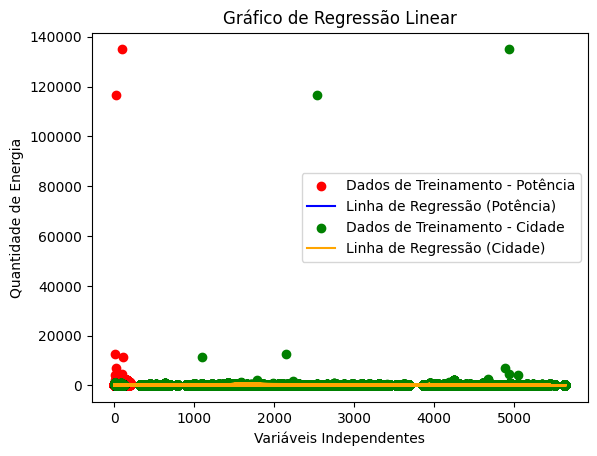

In [14]:
# Relação entre 'potencia' e 'quantidade'
plt.scatter(X_test['potencia'], y_test, color='red', label='Dados de Treinamento - Potência')

# Predição para a 'potencia'
plt.plot(X_test['potencia'], regressor.predict(X_test), color='blue', label='Linha de Regressão (Potência)')

# Visualizando a relação entre 'id_cidade' e 'quantidade'
plt.scatter(X_test['id_cidade'], y_test, color='green', label='Dados de Treinamento - Cidade')

# Predição para o 'id_cidade'
plt.plot(X_test['id_cidade'], regressor.predict(X_test), color='orange', label='Linha de Regressão (Cidade)')

plt.title('Gráfico de Regressão Linear')
plt.xlabel('Variáveis Independentes')
plt.ylabel('Quantidade de Energia')
plt.legend()

plt.show()